In [20]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#!{sys.executable} -m pip install bayesian_optimization
from bayes_opt import BayesianOptimization

# SETTINGS
seed = 124
np.random.seed(seed)
np.set_printoptions(precision=14)

test_size = 0.1

In [21]:
def get_data():

    ## train & test paths
    data_dir = "./data/"

    ### csv w/ layout: "y,x1,x2,x3,x4,x5"
    train_features_file = data_dir+"train_features.csv"
    train_labels_file = data_dir+"train_labels.csv"
    test_features_file = data_dir+"test_features.csv"
    
    data_type = np.double # np dtype object for values in X and Y

    train_features = pd.read_csv(train_features_file)
    train_labels = pd.read_csv(train_labels_file)
    test_features = pd.read_csv(test_features_file)

    return train_features, train_labels, test_features

In [22]:
train_features, train_labels, test_features = get_data()

In [23]:
print(train_features.head())
print(train_features.columns)
train_features.info()

   pid  Time   Age  EtCO2  PTT   BUN  Lactate  Temp  Hgb  HCO3  BaseExcess  \
0    1     3  34.0    NaN  NaN  12.0      NaN  36.0  8.7  24.0        -2.0   
1    1     4  34.0    NaN  NaN   NaN      NaN  36.0  NaN   NaN        -2.0   
2    1     5  34.0    NaN  NaN   NaN      NaN  36.0  NaN   NaN         0.0   
3    1     6  34.0    NaN  NaN   NaN      NaN  37.0  NaN   NaN         0.0   
4    1     7  34.0    NaN  NaN   NaN      NaN   NaN  NaN   NaN         NaN   

   RRate  Fibrinogen  Phosphate  WBC  Creatinine  PaCO2  AST  FiO2  Platelets  \
0   16.0         NaN        NaN  6.3         NaN   45.0  NaN   NaN        NaN   
1   16.0         NaN        NaN  NaN         NaN    NaN  NaN   0.5        NaN   
2   18.0         NaN        NaN  NaN         NaN   43.0  NaN   0.4        NaN   
3   18.0         NaN        NaN  NaN         NaN    NaN  NaN   NaN        NaN   
4   18.0         NaN        NaN  NaN         NaN    NaN  NaN   NaN        NaN   

   SaO2  Glucose  ABPm  Magnesium  Potassium

In [24]:
# means = train_features.mean()
# # train_features.fillna(0, inplace=True)
# train_features.fillna(means, inplace=True)
# train_features.head()

# train_feature_labels = train_features.columns

# column_names = [f"{label}_{i}" for i in range(12) for label in train_feature_labels]


In [25]:
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

def reshape(train_features):
    preprocessed_train_features_arr = []
    grouped_pid = train_features.groupby("pid")
    for pid, group in tqdm(grouped_pid):
        # print(group)

        row_arr = []
        min_time = group['Time'].min()
        # imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        # imp.fit(group)
        # print(group, group.columns)
        # imputed =  SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(group.values)
        # print(imputed)
        # group[:] = imputed
        # group = PandasSimpleImputer().fit_transform(group)
        # print(group, group.columns)
        means = group.mean()
        group.fillna(means, inplace=True)
        for i, row in group.iterrows():
            # row = row.to_frame()
            age = row["Age"]
            time = int(row["Time"] - min_time)
            row = row.drop(["pid", "Age", "Time"])
            row = row.add_suffix(f"_{str(time)}")
            row_arr.append(row)
        # print(df)

        pid_age_df = pd.DataFrame({"pid": pid, "Age": float(age)}, index=[0]).T
        
        # column_names = [f"{label}_{i}" for i in range(12) for label in pid_age_df.columns ].append("pid", "Age")
        row_arr.append(pid_age_df)
        final_row = pd.concat(row_arr)
        # print("row_arr", final_row, "end_row_arr", len(row_arr))

        preprocessed_train_features_arr.append(final_row.T)
        


    preprocessed_train_features = pd.concat(preprocessed_train_features_arr, axis=0, ignore_index=True)

    return preprocessed_train_features

pd.set_option('display.max_columns', None)
preprocessed_train_features = reshape(train_features)

from sklearn import preprocessing
# preprocessed_train_features_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(preprocessed_train_features), columns=preprocessed_train_features.columns)

# print(preprocessed_train_features.sort_index(axis=1).head())
# preprocessed_train_features_scaled.fillna(preprocessed_train_features_scaled.mean(), inplace=True)
preprocessed_train_features.to_csv("./data/preprocessed_train_features.csv", index=False)
print(preprocessed_train_features.sort_index(axis=1).head())

100%|██████████| 18995/18995 [05:42<00:00, 55.43it/s]


       ABPd_0  ABPd_1  ABPd_10  ABPd_11  ABPd_2  ABPd_3  ABPd_4  ABPd_5  \
0   61.000000    62.5     49.0     39.0    59.0    49.5    48.0    51.0   
1   70.090909    77.0     71.0     76.0    58.0    66.0    79.0    62.0   
2   49.600000    50.0     44.0     44.0    52.0    49.6    70.0    48.0   
3   46.000000    45.0     50.0     51.0    42.0    50.5    55.5    47.5   
4  108.954545   107.5    142.0    118.0   100.0    98.0   111.0   100.0   

   ABPd_6  ABPd_7  ABPd_8  ABPd_9      ABPm_0  ABPm_1  ABPm_10  ABPm_11  \
0    46.0    47.0    47.0    44.0   84.000000    81.0     69.0     53.0   
1    72.0    72.0    65.0    73.0   94.636364   106.0     94.0     99.0   
2    56.0    50.0    42.0    40.0   80.909091    74.0     60.0     62.0   
3    50.5    51.0    49.0    48.0   61.000000    60.0     68.0     67.0   
4   115.0   100.5   116.0    90.5  143.900000   138.0    169.0    154.0   

   ABPm_2  ABPm_3  ABPm_4  ABPm_5  ABPm_6  ABPm_7  ABPm_8  ABPm_9      ABPs_0  \
0    74.0    66.0

In [26]:

preprocessed_train_features_scaled = pd.read_csv("./data/preprocessed_train_features.csv")

In [27]:

preprocessed_train_features_scaled.fillna(preprocessed_train_features_scaled.mean(), inplace=True)
preprocessed_train_features_scaled

,EtCO2_0,PTT_0,BUN_0,Lactate_0,Temp_0,Hgb_0,HCO3_0,BaseExcess_0,RRate_0,Fibrinogen_0,Phosphate_0,WBC_0,Creatinine_0,PaCO2_0,AST_0,FiO2_0,Platelets_0,SaO2_0,Glucose_0,ABPm_0,Magnesium_0,Potassium_0,ABPd_0,Calcium_0,Alkalinephos_0,SpO2_0,Bilirubin_direct_0,Chloride_0,Hct_0,Heartrate_0,Bilirubin_total_0,TroponinI_0,ABPs_0,pH_0,EtCO2_1,PTT_1,BUN_1,Lactate_1,Temp_1,Hgb_1,HCO3_1,BaseExcess_1,RRate_1,Fibrinogen_1,Phosphate_1,WBC_1,Creatinine_1,PaCO2_1,AST_1,FiO2_1,Platelets_1,SaO2_1,Glucose_1,ABPm_1,Magnesium_1,Potassium_1,ABPd_1,Calcium_1,Alkalinephos_1,SpO2_1,Bilirubin_direct_1,Chloride_1,Hct_1,Heartrate_1,Bilirubin_total_1,TroponinI_1,ABPs_1,pH_1,EtCO2_2,PTT_2,BUN_2,Lactate_2,Temp_2,Hgb_2,HCO3_2,BaseExcess_2,RRate_2,Fibrinogen_2,Phosphate_2,WBC_2,Creatinine_2,PaCO2_2,AST_2,FiO2_2,Platelets_2,SaO2_2,Glucose_2,ABPm_2,Magnesium_2,Potassium_2,ABPd_2,Calcium_2,Alkalinephos_2,SpO2_2,Bilirubin_direct_2,Chloride_2,Hct_2,Heartrate_2,Bilirubin_total_2,TroponinI_2,ABPs_2,pH_2,EtCO2_3,PTT_3,BUN_3,Lactate_3,Temp_3,Hgb_3,HCO3_3,BaseExcess_3,RRate_3,Fibrinogen_3,Phosphate_3,WBC_3,Creatinine_3,PaCO2_3,AST_3,FiO2_3,Platelets_3,SaO2_3,Glucose_3,ABPm_3,Magnesium_3,Potassium_3,ABPd_3,Calcium_3,Alkalinephos_3,SpO2_3,Bilirubin_direct_3,Chloride_3,Hct_3,Heartrate_3,Bilirubin_total_3,TroponinI_3,ABPs_3,pH_3,EtCO2_4,PTT_4,BUN_4,Lactate_4,Temp_4,Hgb_4,HCO3_4,BaseExcess_4,RRate_4,Fibrinogen_4,Phosphate_4,WBC_4,Creatinine_4,PaCO2_4,AST_4,FiO2_4,Platelets_4,SaO2_4,Glucose_4,ABPm_4,Magnesium_4,Potassium_4,ABPd_4,Calcium_4,Alkalinephos_4,SpO2_4,Bilirubin_direct_4,Chloride_4,Hct_4,Heartrate_4,Bilirubin_total_4,TroponinI_4,ABPs_4,pH_4,EtCO2_5,PTT_5,BUN_5,Lactate_5,Temp_5,Hgb_5,HCO3_5,BaseExcess_5,RRate_5,Fibrinogen_5,Phosphate_5,WBC_5,Creatinine_5,PaCO2_5,AST_5,FiO2_5,Platelets_5,SaO2_5,Glucose_5,ABPm_5,Magnesium_5,Potassium_5,ABPd_5,Calcium_5,Alkalinephos_5,SpO2_5,Bilirubin_direct_5,Chloride_5,Hct_5,Heartrate_5,Bilirubin_total_5,TroponinI_5,ABPs_5,pH_5,EtCO2_6,PTT_6,BUN_6,Lactate_6,Temp_6,Hgb_6,HCO3_6,BaseExcess_6,RRate_6,Fibrinogen_6,Phosphate_6,WBC_6,Creatinine_6,PaCO2_6,AST_6,FiO2_6,Platelets_6,SaO2_6,Glucose_6,ABPm_6,Magnesium_6,Potassium_6,ABPd_6,Calcium_6,Alkalinephos_6,SpO2_6,Bilirubin_direct_6,Chloride_6,Hct_6,Heartrate_6,Bilirubin_total_6,TroponinI_6,ABPs_6,pH_6,EtCO2_7,PTT_7,BUN_7,Lactate_7,Temp_7,Hgb_7,HCO3_7,BaseExcess_7,RRate_7,Fibrinogen_7,Phosphate_7,WBC_7,Creatinine_7,PaCO2_7,AST_7,FiO2_7,Platelets_7,SaO2_7,Glucose_7,ABPm_7,Magnesium_7,Potassium_7,ABPd_7,Calcium_7,Alkalinephos_7,SpO2_7,Bilirubin_direct_7,Chloride_7,Hct_7,Heartrate_7,Bilirubin_total_7,TroponinI_7,ABPs_7,pH_7,EtCO2_8,PTT_8,BUN_8,Lactate_8,Temp_8,Hgb_8,HCO3_8,BaseExcess_8,RRate_8,Fibrinogen_8,Phosphate_8,WBC_8,Creatinine_8,PaCO2_8,AST_8,FiO2_8,Platelets_8,SaO2_8,Glucose_8,ABPm_8,Magnesium_8,Potassium_8,ABPd_8,Calcium_8,Alkalinephos_8,SpO2_8,Bilirubin_direct_8,Chloride_8,Hct_8,Heartrate_8,Bilirubin_total_8,TroponinI_8,ABPs_8,pH_8,EtCO2_9,PTT_9,BUN_9,Lactate_9,Temp_9,Hgb_9,HCO3_9,BaseExcess_9,RRate_9,Fibrinogen_9,Phosphate_9,WBC_9,Creatinine_9,PaCO2_9,AST_9,FiO2_9,Platelets_9,SaO2_9,Glucose_9,ABPm_9,Magnesium_9,Potassium_9,ABPd_9,Calcium_9,Alkalinephos_9,SpO2_9,Bilirubin_direct_9,Chloride_9,Hct_9,Heartrate_9,Bilirubin_total_9,TroponinI_9,ABPs_9,pH_9,EtCO2_10,PTT_10,BUN_10,Lactate_10,Temp_10,Hgb_10,HCO3_10,BaseExcess_10,RRate_10,Fibrinogen_10,Phosphate_10,WBC_10,Creatinine_10,PaCO2_10,AST_10,FiO2_10,Platelets_10,SaO2_10,Glucose_10,ABPm_10,Magnesium_10,Potassium_10,ABPd_10,Calcium_10,Alkalinephos_10,SpO2_10,Bilirubin_direct_10,Chloride_10,Hct_10,Heartrate_10,Bilirubin_total_10,TroponinI_10,ABPs_10,pH_10,EtCO2_11,PTT_11,BUN_11,Lactate_11,Temp_11,Hgb_11,HCO3_11,BaseExcess_11,RRate_11,Fibrinogen_11,Phosphate_11,WBC_11,Creatinine_11,PaCO2_11,AST_11,FiO2_11,Platelets_11,SaO2_11,Glucose_11,ABPm_11,Magnesium_11,Potassium_11,ABPd_11,Calcium_11,Alkalinephos_11,SpO2_11,Bilirubin_direct_11,Chloride_11,Hct_11,Heartrate_11,Bilirubin_total_11,TroponinI_11,ABPs_11,pH_11,pid,Age
0,32.711509,39.008197,1

In [28]:

preprocessed_train_features_scaled.sort_values('pid', inplace=True)
train_labels.sort_values('pid', inplace=True)

# 1. Subtask
labels_to_predict = ["LABEL_BaseExcess", "LABEL_Fibrinogen", "LABEL_AST", "LABEL_Alkalinephos", "LABEL_Bilirubin_total", "LABEL_Lactate", "LABEL_TroponinI", "LABEL_SaO2", "LABEL_Bilirubin_direct", "LABEL_EtCO2"]
y1 = train_labels[labels_to_predict]
print(y1.info())
preprocessed_train_features_scaled.drop('pid', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18995 entries, 0 to 14406
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LABEL_BaseExcess        18995 non-null  float64
 1   LABEL_Fibrinogen        18995 non-null  float64
 2   LABEL_AST               18995 non-null  float64
 3   LABEL_Alkalinephos      18995 non-null  float64
 4   LABEL_Bilirubin_total   18995 non-null  float64
 5   LABEL_Lactate           18995 non-null  float64
 6   LABEL_TroponinI         18995 non-null  float64
 7   LABEL_SaO2              18995 non-null  float64
 8   LABEL_Bilirubin_direct  18995 non-null  float64
 9   LABEL_EtCO2             18995 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB
None


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_features_scaled, y1, test_size=test_size, random_state=seed)

In [30]:
X_train, y_train

(         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
 1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
 7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
 10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
 10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
 94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
 ...          ...        ...        ...        ...        ...        ...   
 681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
 9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
 14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
 4764   32.711509  34.000000  23.013833   2.420076  37.000000  10.743874   
 4558   32.711509  39.008197  18.000000   2.420076  37.000000  13.700000   
 
           HCO3_0  BaseExcess_0    RRate_0  Fibrinogen_0  Phosphate_0  \
 1055   23.78

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17095 entries, 1055 to 4558
Columns: 409 entries, EtCO2_0 to Age
dtypes: float64(409)
memory usage: 53.5 MB


In [32]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization

print(X_train.iloc[0], y_train.iloc[0])

# from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

print(X_train, y_train)



EtCO2_0                32.711509
PTT_0                  39.008197
BUN_0                  19.000000
Lactate_0               1.500000
Temp_0                 36.500000
                         ...    
Bilirubin_total_11      1.800000
TroponinI_11            6.475293
ABPs_11               112.000000
pH_11                   7.500000
Age                    66.000000
Name: 1055, Length: 409, dtype: float64 LABEL_BaseExcess          0.0
LABEL_Fibrinogen          0.0
LABEL_AST                 0.0
LABEL_Alkalinephos        0.0
LABEL_Bilirubin_total     0.0
LABEL_Lactate             0.0
LABEL_TroponinI           0.0
LABEL_SaO2                0.0
LABEL_Bilirubin_direct    0.0
LABEL_EtCO2               1.0
Name: 5250, dtype: float64
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.50

LABEL_BaseExcess
['BaseExcess_0', 'BaseExcess_1', 'BaseExcess_2', 'BaseExcess_3', 'BaseExcess_4', 'BaseExcess_5', 'BaseExcess_6', 'BaseExcess_7', 'BaseExcess_8', 'BaseExcess_9', 'BaseExcess_10', 'BaseExcess_11', 'Age']
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
...          ...        ...        ...        ...        ...        ...   
681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
4764   32.711509  34.000000  23

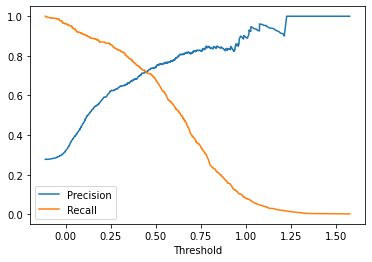

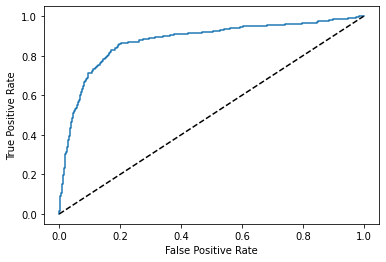

LABEL_Fibrinogen
['Fibrinogen_0', 'Fibrinogen_1', 'Fibrinogen_2', 'Fibrinogen_3', 'Fibrinogen_4', 'Fibrinogen_5', 'Fibrinogen_6', 'Fibrinogen_7', 'Fibrinogen_8', 'Fibrinogen_9', 'Fibrinogen_10', 'Fibrinogen_11', 'Age']
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
...          ...        ...        ...        ...        ...        ...   
681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
4764   32.711509  34.000000  23

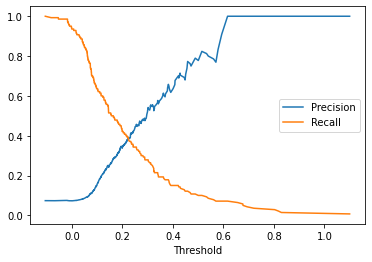

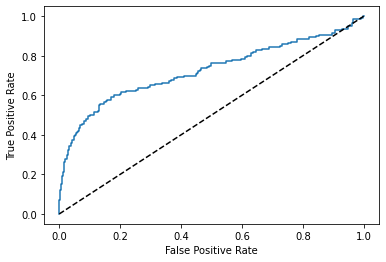

LABEL_AST
['AST_0', 'AST_1', 'AST_2', 'AST_3', 'AST_4', 'AST_5', 'AST_6', 'AST_7', 'AST_8', 'AST_9', 'AST_10', 'AST_11', 'Age']
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
...          ...        ...        ...        ...        ...        ...   
681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
4764   32.711509  34.000000  23.013833   2.420076  37.000000  10.743874   
4558   32.711509  39.008197  18.000000   2.4200

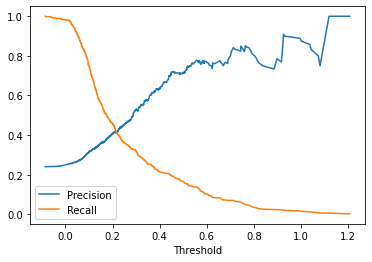

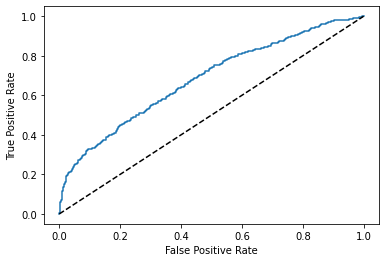

LABEL_Alkalinephos
['Alkalinephos_0', 'Alkalinephos_1', 'Alkalinephos_2', 'Alkalinephos_3', 'Alkalinephos_4', 'Alkalinephos_5', 'Alkalinephos_6', 'Alkalinephos_7', 'Alkalinephos_8', 'Alkalinephos_9', 'Alkalinephos_10', 'Alkalinephos_11', 'Age']
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
...          ...        ...        ...        ...        ...        ...   
681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
4764 

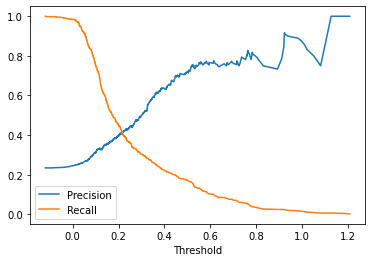

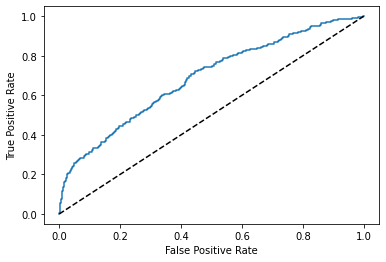

LABEL_Bilirubin_total
['Bilirubin_total_0', 'Bilirubin_total_1', 'Bilirubin_total_2', 'Bilirubin_total_3', 'Bilirubin_total_4', 'Bilirubin_total_5', 'Bilirubin_total_6', 'Bilirubin_total_7', 'Bilirubin_total_8', 'Bilirubin_total_9', 'Bilirubin_total_10', 'Bilirubin_total_11', 'Age']
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
...          ...        ...        ...        ...        ...        ...   
681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
14353  32.711509  39.008197  24.000000   

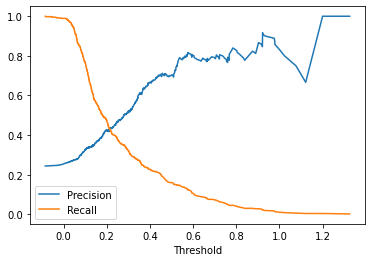

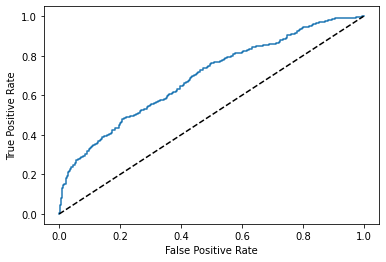

LABEL_Lactate
['Lactate_0', 'Lactate_1', 'Lactate_2', 'Lactate_3', 'Lactate_4', 'Lactate_5', 'Lactate_6', 'Lactate_7', 'Lactate_8', 'Lactate_9', 'Lactate_10', 'Lactate_11', 'Age']
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
1055   32.711509  39.008197  19.000000   1.500000  36.500000   8.750000   
7611   32.711509  39.008197  16.000000   2.420076  36.666667  11.300000   
10976  32.711509  27.750000  50.500000   2.500000  36.666667   9.800000   
10171  32.711509  39.008197  23.013833   2.420076  36.666667  10.743874   
94     32.711509  29.900000  62.000000   2.420076  36.500000  13.150000   
...          ...        ...        ...        ...        ...        ...   
681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
4764   32.711509  34.000000  23.013833   2.420076  37.000000  10.74387

KeyboardInterrupt: 

In [43]:

preds_arr = []
for label in labels_to_predict:
    print(label)
    # clf = LogisticRegressionCV(class_weight='balanced', penalty='l2', n_jobs=6, cv=10, max_iter=1000, scoring="roc_auc", random_state=seed)
    # clf = LinearSVC(probability=True, class_weight='balanced', kernel='linear')
    regr = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.1))
    
    
    # cv = RandomizedSearchCV(logistic, distributions, random_state=0)
    # search = RandomCV(pipe, param_grid, n_jobs=2)
    # search.fit(X_digits, y_digits)
    # print("Best parameter (CV score=%0.3f):" % search.best_score_)
    # print(search.best_params_)

    wanted_features = [l for l in X_train.columns if "_".join(label.split("_")[1:]) in l]
    wanted_features.append("Age")
    print(wanted_features)
    X_train_filtered = X_train#[wanted_features]
    X_test_filtered = X_test#[wanted_features]
    print(X_train_filtered)
    
    # scaler = preprocessing.StandardScaler().fit(X_train_filtered)    
    # X_train_scaled = scaler.transform(X_train_filtered)
    # X_test_scaled = scaler.transform(X_test_filtered)
    # print(X_train_scaled)
    # clf.fit(X_train_scaled, y_train[label])
    # print(X_train_filtered)
    regr.fit(X_train_filtered, y_train[label])

    # model = Sequential() # create a sequential model
    # model.add(Dense(1000, # output neurons in layer       
    #         input_dim=X_train.shape[1], # number of inputs
    #         activation='relu')) # activation function
    # model.add(Dense(1000, activation='relu')) # hidden layer
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5)) 
    # # model.add(BatchNormalization())
    # model.add(Dense(2, activation='softmax')) # output layer
    # model.summary()

    # # fit the model
    # callback = EarlyStopping(monitor='val_loss', patience=2)
    # model.compile(loss='binary_crossentropy', # cost function
    #           optimizer='adam', # use adam as the optimizer
    #           metrics=['accuracy', keras.metrics.AUC(),f1_m,precision_m, recall_m]) # compute accuracy, for scoring
    # model_info = model.fit(X_train, to_categorical(y_train[label]), 
    #     epochs=100,
    #     validation_split=.10,
    #     callbacks=[callback])
    
    # loss, accuracy, auc, f1_score, precision, recall = model.evaluate(X_test, to_categorical(y_test[label]), verbose=1)
    # print(f"loss: {loss}, auc: {auc}, accuracy: {accuracy}, f1_score: {f1_score}, precision: {precision}, recall: {recall}")
    # pred = model.predict(X_test)
    # pred_train = model.predict(X_train)
    # print(pred, pred_train)
    # pred = pred.squeeze()[:,1]
    # pred_train = pred_train.squeeze()[:,1]
    # pred = clf.predict_proba(X_test_scaled)[:, 1]
    # pred_train = clf.predict_proba(X_train_scaled)[:, 1]
    pred = regr.predict(X_test_filtered)
    pred_train = regr.predict(X_train_filtered)
    print(pred, pred.var())

    preds_arr.append(pd.DataFrame(pred, columns=[label]))
    # pred = clf.predict_proba(X_test_scaled)
    # score = roc_auc_score(y_test[label], pred[:, 1])
    # score = roc_auc_score(y_test[label], pred)
    # train_score = roc_auc_score(y_train[label], pred_train)
    # print(f"roc auc score: {score}", train_score)


    precisions, recalls, thresholds = precision_recall_curve(y_test[label], pred)

    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    # mean_squared_error(y_test["LABEL_BaseExcess"], pred[:, 1])
    # fpr, tpr, thresholds = roc_curve(y_test[label], pred[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test[label], pred)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
preds = pd.concat(preds_arr)
print(preds)

In [34]:
def save_submission(submission):

    ## prediction submission paths
    sub_dir = "./submission/"
    sub_file = "submission.csv"
    sub_path = sub_dir + sub_file


    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)


    ## submission csv header
    sub_header = ""
    sub_format = "%.13f"
    np.savetxt(sub_path,
               submission,
               fmt = sub_format,
               delimiter = ',',
               header = sub_header,
               comments = '')